## Imports

In [1]:
import math
import os
import time
import random
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
# from feature_extractor import FeatureExtractor
from dataentry import DataEntry
from helpers import jaccard, change_imgpath, vconcat_resize_min, hconcat_resize_max
from utils import *

In [3]:
# Set seed
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(RANDOMSEED)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(RANDOMSEED)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(RANDOMSEED)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
from tensorflow.random import set_seed
set_seed(RANDOMSEED)

## Functions

In [4]:
def humanfriendly_trafo(path):
    if type(path) is str:
        return path.split("/")[-1]
    elif type(path[0]) is str:
        return [entry.split("/")[-1] for entry in path]
    else:
        return [[entry.split("/")[-1] for entry in lst] for lst in path]


def show_humanfriendly(df, columns=["image_name", "near_hits", "near_misses", "top_misses"]):
    dfh = df.copy()
    for c in columns:
        dfh[c] = [humanfriendly_trafo(row) for row in df[c]]
    return dfh

In [5]:
def jaccard_df(df1, df2, method="intersection"):
    if type(df1[0][0]) is list:
        result = [jaccard(list(chain.from_iterable(l1)), list(chain.from_iterable(l2)), method) for
                  l1, l2 in zip(df1, df2)]
        return result
    else:
        result = [jaccard(l1, l2, method) for l1, l2 in zip(df1, df2)]
        return result

## Load pickles

In [6]:
path_base = "/Users/biancazimmer/Documents/PycharmProjects/masterthesis/main_code/static/NHNM/"

mnist_eucl = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_euclidean_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_SSIM = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_SSIM_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_SSIM_mm = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_SSIM-mm_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_SSIM_pushed = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_SSIM-pushed_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_SSIM_blur = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_SSIM-blur_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_CW_SSIM = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_CW-SSIM_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
mnist_SSIM_threshold = pd.read_pickle(path_base+"mnist_1247_cnn_seed3871_SSIM-threshold_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")


oct_eucl = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_euclidean_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
oct_SSIM = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_SSIM_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
oct_SSIM_mm = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_SSIM-mm_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
oct_SSIM_pushed = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_SSIM-pushed_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
oct_SSIM_blur = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_SSIM-blur_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")
oct_SSIM_threshold = pd.read_pickle(path_base+"oct_cc_cnn_seed3871_SSIM-threshold_usepredTrue_rawFalse_distonimgTrue_FINAL100.pickle")

In [7]:
all_df = [mnist_eucl, mnist_SSIM, mnist_SSIM_mm, mnist_SSIM_pushed, mnist_SSIM_blur, mnist_SSIM_threshold, mnist_CW_SSIM,
          oct_eucl, oct_SSIM, oct_SSIM_mm, oct_SSIM_pushed, oct_SSIM_blur, oct_SSIM_threshold]
mnist_df = {"euclidean": mnist_eucl, "SSIM": mnist_SSIM, "SSIM-mm": mnist_SSIM_mm,
            "SSIM-pushed": mnist_SSIM_pushed, "SSIM-blur": mnist_SSIM_blur, "SSIM-threshold": mnist_SSIM_threshold,
            "CW-SSIM": mnist_CW_SSIM}
oct_df = {"euclidean": oct_eucl, "SSIM": oct_SSIM, "SSIM-mm": oct_SSIM_mm, 
          "SSIM-pushed": oct_SSIM_pushed, "SSIM-blur": oct_SSIM_blur, "SSIM-threshold": oct_SSIM_threshold}

## Overview over distance scores

In [8]:
# metrics
metrics = ["eucl", "SSIM", "SSIM-mm", "SSIM-pushed", "SSIM-blur", "SSIM-threshold", "CW-SSIM"]

# column names
scores_names = []
scores_top_names = []
for m in metrics:
    scores_names.append("scores_hit_"+m)
    scores_top_names.append("scores_top_misses_"+m)
scores_top_names

['scores_top_misses_eucl',
 'scores_top_misses_SSIM',
 'scores_top_misses_SSIM-mm',
 'scores_top_misses_SSIM-pushed',
 'scores_top_misses_SSIM-blur',
 'scores_top_misses_SSIM-threshold',
 'scores_top_misses_CW-SSIM']

### MNIST

In [9]:
mnist_scores = pd.DataFrame()


for score_hit, score_top, df in zip(scores_names, scores_top_names, mnist_df.values()):
    mnist_scores[score_hit] = list(chain.from_iterable(df.scores_hits))
    mnist_scores[score_top] = list(chain.from_iterable(df.scores_top_misses))
mnist_scores

,scores_hit_eucl,scores_top_misses_eucl,scores_hit_SSIM,scores_top_misses_SSIM,scores_hit_SSIM-mm,scores_top_misses_SSIM-mm,scores_hit_SSIM-pushed,scores_top_misses_SSIM-pushed,scores_hit_SSIM-blur,scores_top_misses_SSIM-blur,scores_hit_SSIM-threshold,scores_top_misses_SSIM-threshold,scores_hit_CW-SSIM,scores_top_misses_CW-SSIM
0,1416.372832,441.839337,0.018908,0.062483,0.138190,0.267726,0.117655,0.248206,0.000798,0.003250,0.020387,0.055943,0.091293,0.327924
1,2666.929320,451.104201,0.018949,0.062016,0.141839,0.261408,0.135898,0.241223,0.000885,0.003245,0.021089,0.055365,0.102444,0.303616
2,2729.844501,453.070635,0.019119,0.059341,0.147354,0.262420,0.136136,0.242345,0.000923,0.002965,0.023343,0.051947,0.103862,0.332592
3,2914.599629,450.610697,0.019131,0.060410,0.147833,0.266035,0.137369,0.248400,0.000924,0.003249,0.023384,0.055525,0.105240,0.325552
4,2939.936564,454.015418,0.020003,0.062594,0.151047,0.257457,0.137542,0.240602,0.000941,0.003044,0.023622,0.053438,0.105711,0.252747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4631.902309,376.487716,0.013887,0.030341,0.241663,0.262048,0.204450,0.220222,0.000646,0.003085,0.009542,0.024645,0.240588,0.365477
496,4692.785314,376.564735,0.019109,0.030479,0.250338,0.248688,0.211331,0.220131,0.000840,0.002191,0.013698,0.024420,0.250886,0.348924
497,4781.949707,377.522185,0.020069,0.030006,0.250760,0.267653,0.214841,0.220830,0.000919,0.002399,0.015598,0.024501,0.252818,0.428523
498,4787.217668,376.823566,0.020382,0.030046,0.251026,0.263424,0.218946,0.221220,0.000939,0.003079,0.016981,0.024379,0.268986,0.389638


In [10]:
mnist_scores.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
scores_hit_eucl,500.0,3595.115038,1119.067973,385.227206,2997.647673,4091.205477,4373.981157,4962.831752
scores_top_misses_eucl,500.0,392.189656,67.560571,231.090891,347.289107,386.865607,434.549479,656.531035
scores_hit_SSIM,500.0,0.034101,0.012807,0.006847,0.024309,0.035201,0.041095,0.070787
scores_top_misses_SSIM,500.0,0.049636,0.012047,0.023472,0.040216,0.048676,0.057221,0.081090
scores_hit_SSIM-mm,500.0,0.234374,0.045558,0.104150,0.202056,0.237260,0.273115,0.337305
scores_top_misses_SSIM-mm,500.0,0.293142,0.038352,0.194164,0.266571,0.288070,0.323861,0.388697
scores_hit_SSIM-pushed,500.0,0.229457,0.043994,0.116838,0.197950,0.230542,0.264426,0.332632
scores_top_misses_SSIM-pushed,500.0,0.278162,0.038672,0.190184,0.250280,0.273832,0.308062,0.367309
scores_hit_SSIM-blur,500.0,0.001472,0.000672,0.000387,0.001008,0.001424,0.001770,0.004306
scores_top_misses_SSIM-blur,500.0,0.002858,0.001039,0.001015,0.002130,0.002653,0.003347,0.007725


<function matplotlib.pyplot.show(*args, **kw)>

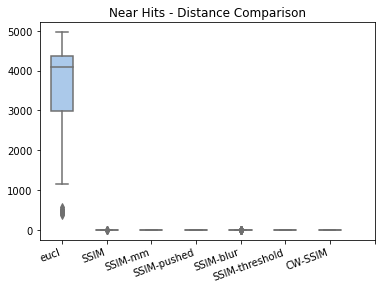

In [11]:
sns.boxplot(data=mnist_scores[scores_names], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_names)+1),
           labels=[name.split("_")[2] for name in scores_names],
           rotation=20, ha="right")
plt.title("Near Hits - Distance Comparison")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

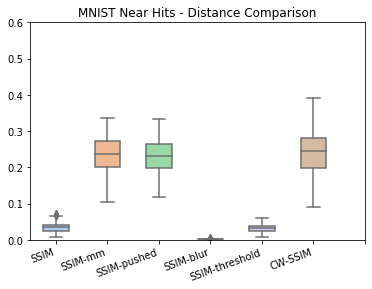

In [12]:
sns.boxplot(data=mnist_scores[scores_names[1:]], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_names[1:])+1),
           labels=[name.split("_")[2] for name in scores_names[1:]],
           rotation=20, ha="right")
plt.ylim([0,0.6])
plt.title("MNIST Near Hits - Distance Comparison")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

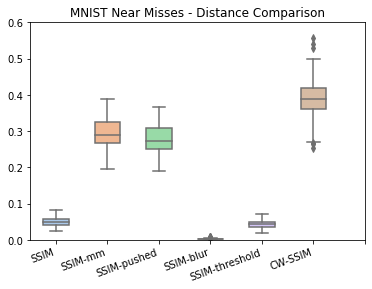

In [13]:
sns.boxplot(data=mnist_scores[scores_top_names[1:]], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_top_names[1:])+1),
           labels=[name.split("_")[3] for name in scores_top_names[1:]],
           rotation=20, ha="right")
plt.ylim([0,0.6])
plt.title("MNIST Near Misses - Distance Comparison")
plt.show

#### Results:

* euclidean distance seems to be lower in Misses than in Hits, which is contraintuitive
* In all SSIM distances the Misses have higher distance values than the Hits - which is what we expected
* SSIM seems to be fairly good compared to the minmax metric, the CW-SSIM and the transformed/pushed metric
* SSIM and SSIM-threshold give very similar results
* SSIM on the blurred + transformed pictures seems to give the best results since the distances between the pictures are minimal (close to 0)

### OCT

In [14]:
oct_scores = pd.DataFrame()


for score_hit, score_top, df in zip(scores_names[:-1], scores_top_names[:-1], oct_df.values()):
    oct_scores[score_hit] = list(chain.from_iterable(df.scores_hits))
    oct_scores[score_top] = list(chain.from_iterable(df.scores_top_misses))
oct_scores

,scores_hit_eucl,scores_top_misses_eucl,scores_hit_SSIM,scores_top_misses_SSIM,scores_hit_SSIM-mm,scores_top_misses_SSIM-mm,scores_hit_SSIM-pushed,scores_top_misses_SSIM-pushed,scores_hit_SSIM-blur,scores_top_misses_SSIM-blur,scores_hit_SSIM-threshold,scores_top_misses_SSIM-threshold
0,14420.434598,9304.900214,0.015469,0.015525,0.151062,0.158829,0.140579,0.140029,0.004119,0.003821,0.016561,0.017989
1,14663.690736,9470.934114,0.015475,0.015479,0.152550,0.150477,0.140848,0.146463,0.004360,0.003821,0.016678,0.017899
2,15024.712044,9529.795381,0.015485,0.015427,0.152817,0.155784,0.142026,0.146497,0.004517,0.004376,0.016734,0.017941
3,15032.883456,9529.669144,0.015502,0.015188,0.153127,0.154963,0.145922,0.144293,0.004636,0.004536,0.016742,0.017941
4,15393.995031,9678.653935,0.015506,0.015347,0.155017,0.154963,0.147265,0.144293,0.004639,0.004632,0.016776,0.017975
...,...,...,...,...,...,...,...,...,...,...,...,...
495,8441.527409,9423.717950,0.020402,0.020787,0.257810,0.264907,0.246460,0.247396,0.006488,0.007197,0.002551,0.002773
496,8441.527409,9101.741976,0.020587,0.020981,0.258946,0.263248,0.246520,0.249079,0.006488,0.007146,0.002628,0.002645
497,8854.034899,9327.154764,0.020674,0.020968,0.258946,0.264229,0.246520,0.248677,0.006568,0.007174,0.002760,0.002541
498,8980.800799,9471.324142,0.020709,0.020943,0.258946,0.264171,0.246614,0.249139,0.006593,0.007252,0.002778,0.002132


In [15]:
oct_scores.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
scores_hit_eucl,500.0,9226.875830,6085.075027,255.000000,5693.360589,7521.564387,10905.063496,34792.323837
scores_top_misses_eucl,500.0,7310.654345,6933.800145,539.977777,2793.522974,5350.644278,9164.416279,40609.105063
scores_hit_SSIM,500.0,0.013809,0.008195,0.000000,0.008248,0.012181,0.018006,0.050804
scores_top_misses_SSIM,500.0,0.014188,0.008169,0.002208,0.008705,0.012231,0.018462,0.050947
scores_hit_SSIM-mm,500.0,0.194489,0.079538,0.000000,0.135099,0.184838,0.253603,0.376397
scores_top_misses_SSIM-mm,500.0,0.199599,0.079735,0.062574,0.142872,0.193796,0.257943,0.380114
scores_hit_SSIM-pushed,500.0,0.180536,0.082630,0.000000,0.128192,0.168012,0.222997,0.428923
scores_top_misses_SSIM-pushed,500.0,0.183686,0.081560,0.060071,0.131321,0.171842,0.225295,0.429078
scores_hit_SSIM-blur,500.0,0.003369,0.001951,0.000000,0.001857,0.003074,0.004425,0.010260
scores_top_misses_SSIM-blur,500.0,0.003867,0.001957,0.000453,0.002518,0.003477,0.004790,0.010305


<function matplotlib.pyplot.show(*args, **kw)>

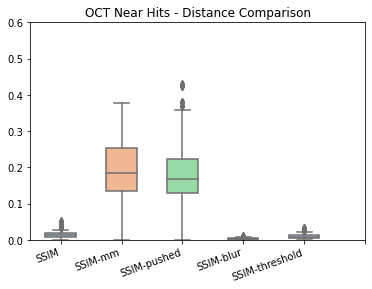

In [16]:
sns.boxplot(data=oct_scores[scores_names[1:-1]], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_names[1:-1])+1),
           labels=[name.split("_")[2] for name in scores_names[1:-1]],
           rotation=20, ha="right")
plt.ylim([0,0.6])
plt.title("OCT Near Hits - Distance Comparison")
plt.show

oct_scores.boxplot(column=scores_names[1:-1], rot= 10)

<function matplotlib.pyplot.show(*args, **kw)>

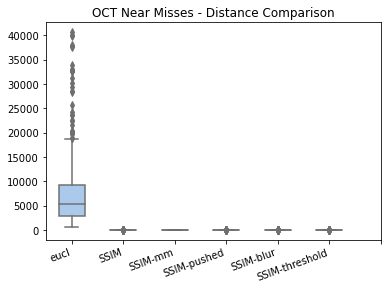

In [17]:
sns.boxplot(data=oct_scores[scores_top_names[:-1]], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_top_names[:-1])+1),
           labels=[name.split("_")[3] for name in scores_top_names[:-1]],
           rotation=20, ha="right")
plt.title("OCT Near Misses - Distance Comparison")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

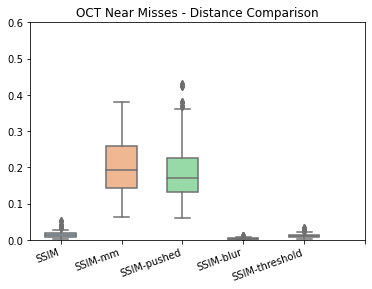

In [18]:
sns.boxplot(data=oct_scores[scores_top_names[1:-1]], palette="pastel", width=0.5)
plt.xticks(ticks=range(0, len(scores_top_names[1:-1])+1),
           labels=[name.split("_")[3] for name in scores_top_names[1:-1]],
           rotation=20, ha="right")
plt.ylim([0,0.6])
plt.title("OCT Near Misses - Distance Comparison")
plt.show

#### Results:
Similar to those of the MNIST dataset

Probably need more values to varify this but runtime too long

## Calculate Jaccard indices

In [19]:
def jaccard_nhnmtm(df1, df2, group=None, df1_name=None, df2_name=None):
    res = pd.DataFrame()
    # hits
    res["jaccard_hits"] = jaccard_df(df1.near_hits, df2.near_hits)
    res["jaccard_hits_abs"] = jaccard_df(df1.near_hits, df2.near_hits, "absolute")
    # misses
    res["jaccard_misses"] = jaccard_df(df1.near_misses, df2.near_misses)
    res["jaccard_misses_abs"] = jaccard_df(df1.near_misses, df2.near_misses, "absolute")
    # top misses
    res["jaccard_top_misses"] = jaccard_df(df1.top_misses, df2.top_misses)
    res["jaccard_top_misses_abs"] = jaccard_df(df1.top_misses, df2.top_misses, "absolute")
    # set group
    if group is not None:
        res["group"] = group
        res["df1_name"] = df1_name
        res["df2_name"] = df2_name
    return res

In [20]:
def sort_triangular(matrix):
    """ Takes matrix/DataFrame as input and sorts columns and rows into an upper triangular matrix if rest is NAN

    :param matrix: pandas.DataFrame
    :return: pandas.DataFrame with sorted columns and rows
    """
    nan_count_c = matrix.apply(lambda x: x.isna().sum(), axis=0)
    nan_count_r = matrix.apply(lambda x: x.isna().sum(), axis=1)
    triangular = matrix.iloc[np.argsort(nan_count_r), np.argsort(-nan_count_c)]
    return triangular

In [21]:
# jaccards.groupby(["df1_name", "df2_name"]).describe()

def jaccards_heatmap(jaccards_df, column, title = None, vmin=None, vmax=None):
    """
    :param columns: str, one of "jaccard_misses", "jaccard_top_misses", "jaccard_hits", "jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"
    """
    mean_topmisses = jaccards_df[[column,
                                  "df1_name", "df2_name"]].groupby(["df1_name", "df2_name"]).median().unstack()
    mean_topmisses.columns = mean_topmisses.columns.get_level_values(1)
    mean_topmisses = sort_triangular(mean_topmisses)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale=1.3)
    if (vmin is None) and (vmax is None):
        ax = sns.heatmap(mean_topmisses, annot=True, fmt=".3f", cmap='viridis', square = True)
    else:
        ax = sns.heatmap(mean_topmisses, annot=True, fmt=".3f", cmap='viridis', square = True,
                        vmin=vmin, vmax=vmax)
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    texts = [t for t in ax.get_xticklabels()]
    plt.xticks(ticks=np.arange(0, len(texts))+0.5,
           labels=texts,
           rotation=90, ha="center")
    if title is None:
        title = column
    plt.title(title)
    plt.show()

### MNIST

In [22]:
jaccards = pd.DataFrame()
for m1, df1 in mnist_df.items():
    for m2, df2 in mnist_df.items():
        # print(m1+"_"+m2)
        if m1 == m2:
            continue
        try:
            if m2+"_"+m1 in np.array(jaccards.group):
                continue
        except AttributeError:
            pass
        new = jaccard_nhnmtm(df1, df2, group = m1+"_"+m2, df1_name=m1, df2_name=m2)
        jaccards = pd.concat([jaccards, new], ignore_index = True)
        
jaccards

,jaccard_hits,jaccard_hits_abs,jaccard_misses,jaccard_misses_abs,jaccard_top_misses,jaccard_top_misses_abs,group,df1_name,df2_name
0,0.000000,0,0.250000,6,0.000000,0,euclidean_SSIM,euclidean,SSIM
1,0.000000,0,0.250000,6,0.111111,1,euclidean_SSIM,euclidean,SSIM
2,0.000000,0,0.071429,2,0.000000,0,euclidean_SSIM,euclidean,SSIM
3,0.111111,1,0.111111,3,0.000000,0,euclidean_SSIM,euclidean,SSIM
4,0.111111,1,0.250000,6,0.250000,2,euclidean_SSIM,euclidean,SSIM
...,...,...,...,...,...,...,...,...,...
2095,0.000000,0,0.000000,0,0.000000,0,SSIM-threshold_CW-SSIM,SSIM-threshold,CW-SSIM
2096,0.000000,0,0.034483,1,0.000000,0,SSIM-threshold_CW-SSIM,SSIM-threshold,CW-SSIM
2097,0.000000,0,0.000000,0,0.000000,0,SSIM-threshold_CW-SSIM,SSIM-threshold,CW-SSIM
2098,0.000000,0,0.000000,0,0.000000,0,SSIM-threshold_CW-SSIM,SSIM-threshold,CW-SSIM


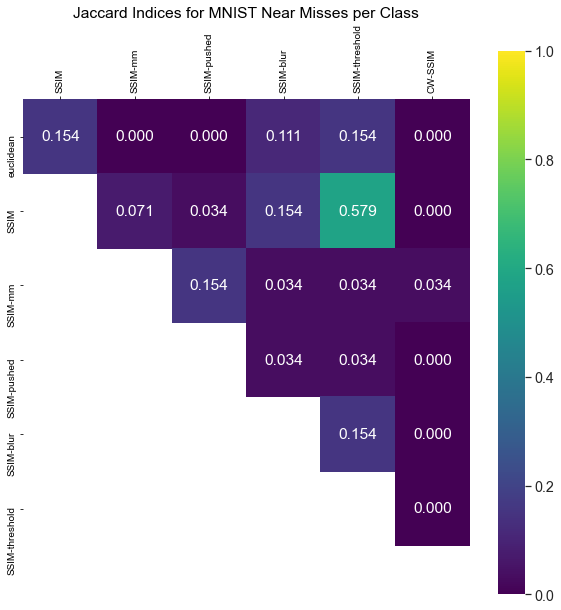

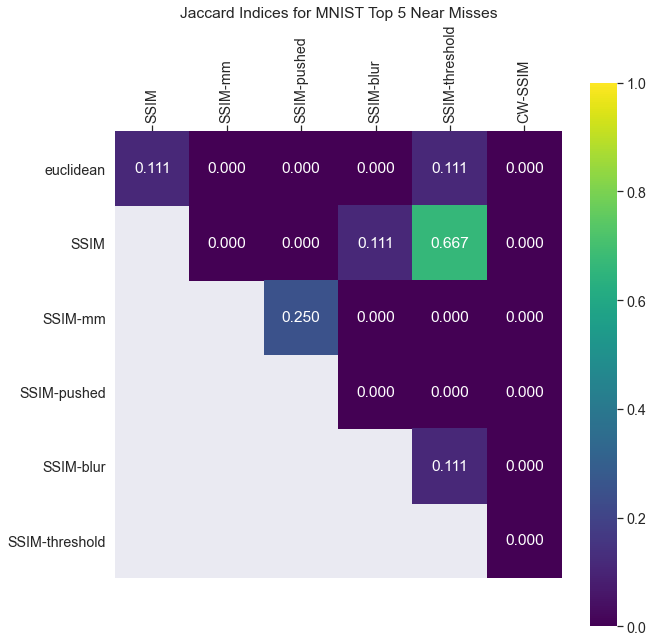

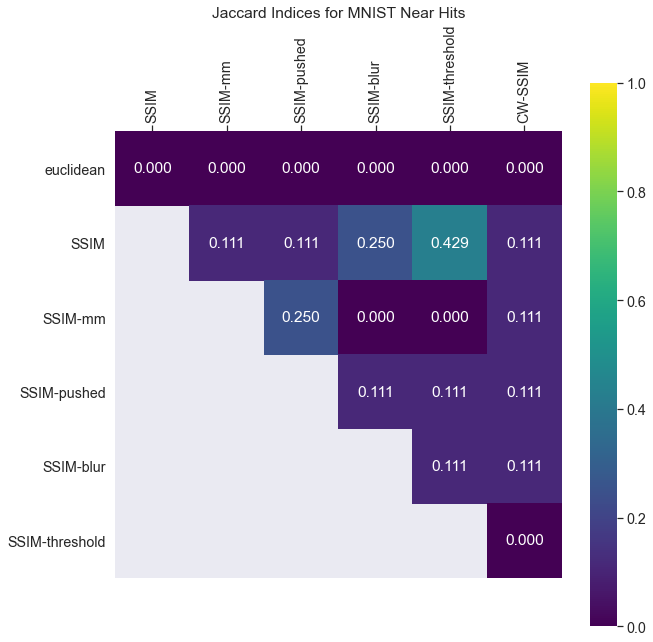

In [23]:
jaccards_heatmap(jaccards, "jaccard_misses", vmax=1, title = "Jaccard Indices for MNIST Near Misses per Class")
jaccards_heatmap(jaccards, "jaccard_top_misses", vmax=1, title = "Jaccard Indices for MNIST Top 5 Near Misses")
jaccards_heatmap(jaccards, "jaccard_hits", vmax=1, title = "Jaccard Indices for MNIST Near Hits")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc460187d30>,
      dtype=object)

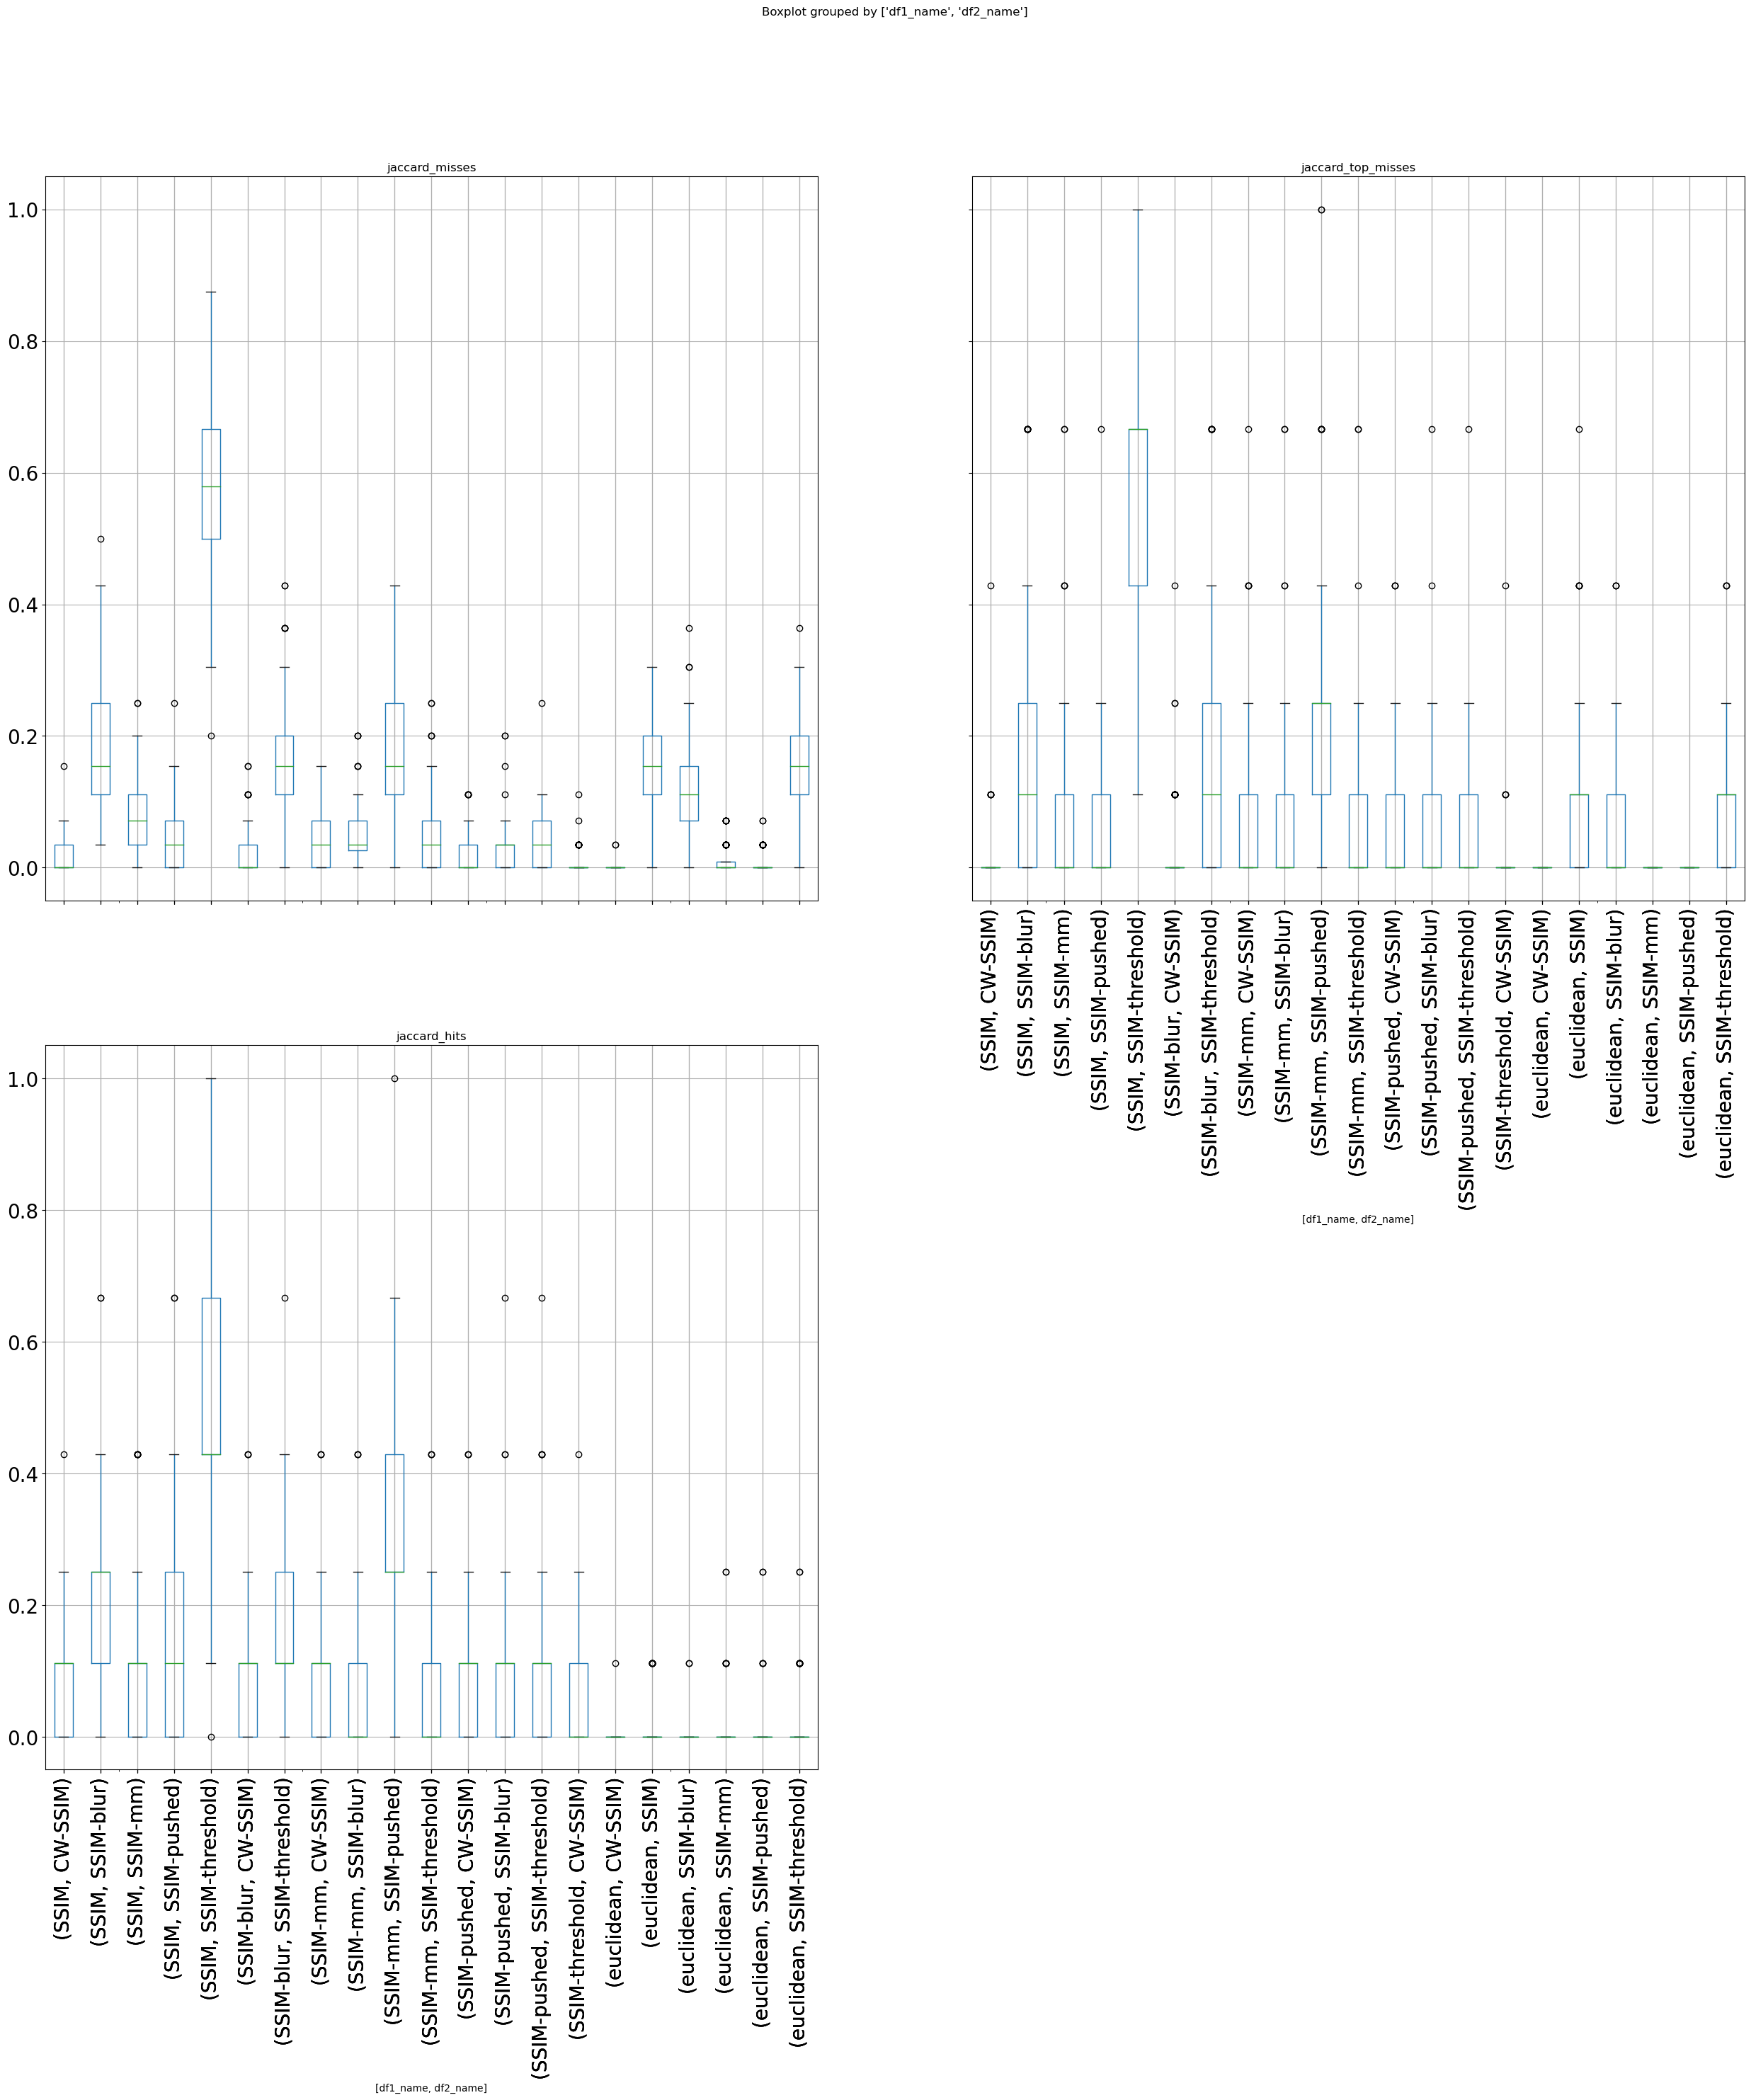

In [24]:
sns.reset_defaults()
jaccards.boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], by=["df1_name", "df2_name"],
                figsize=(30,30), rot = 90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4a3ca8c10>,
      dtype=object)

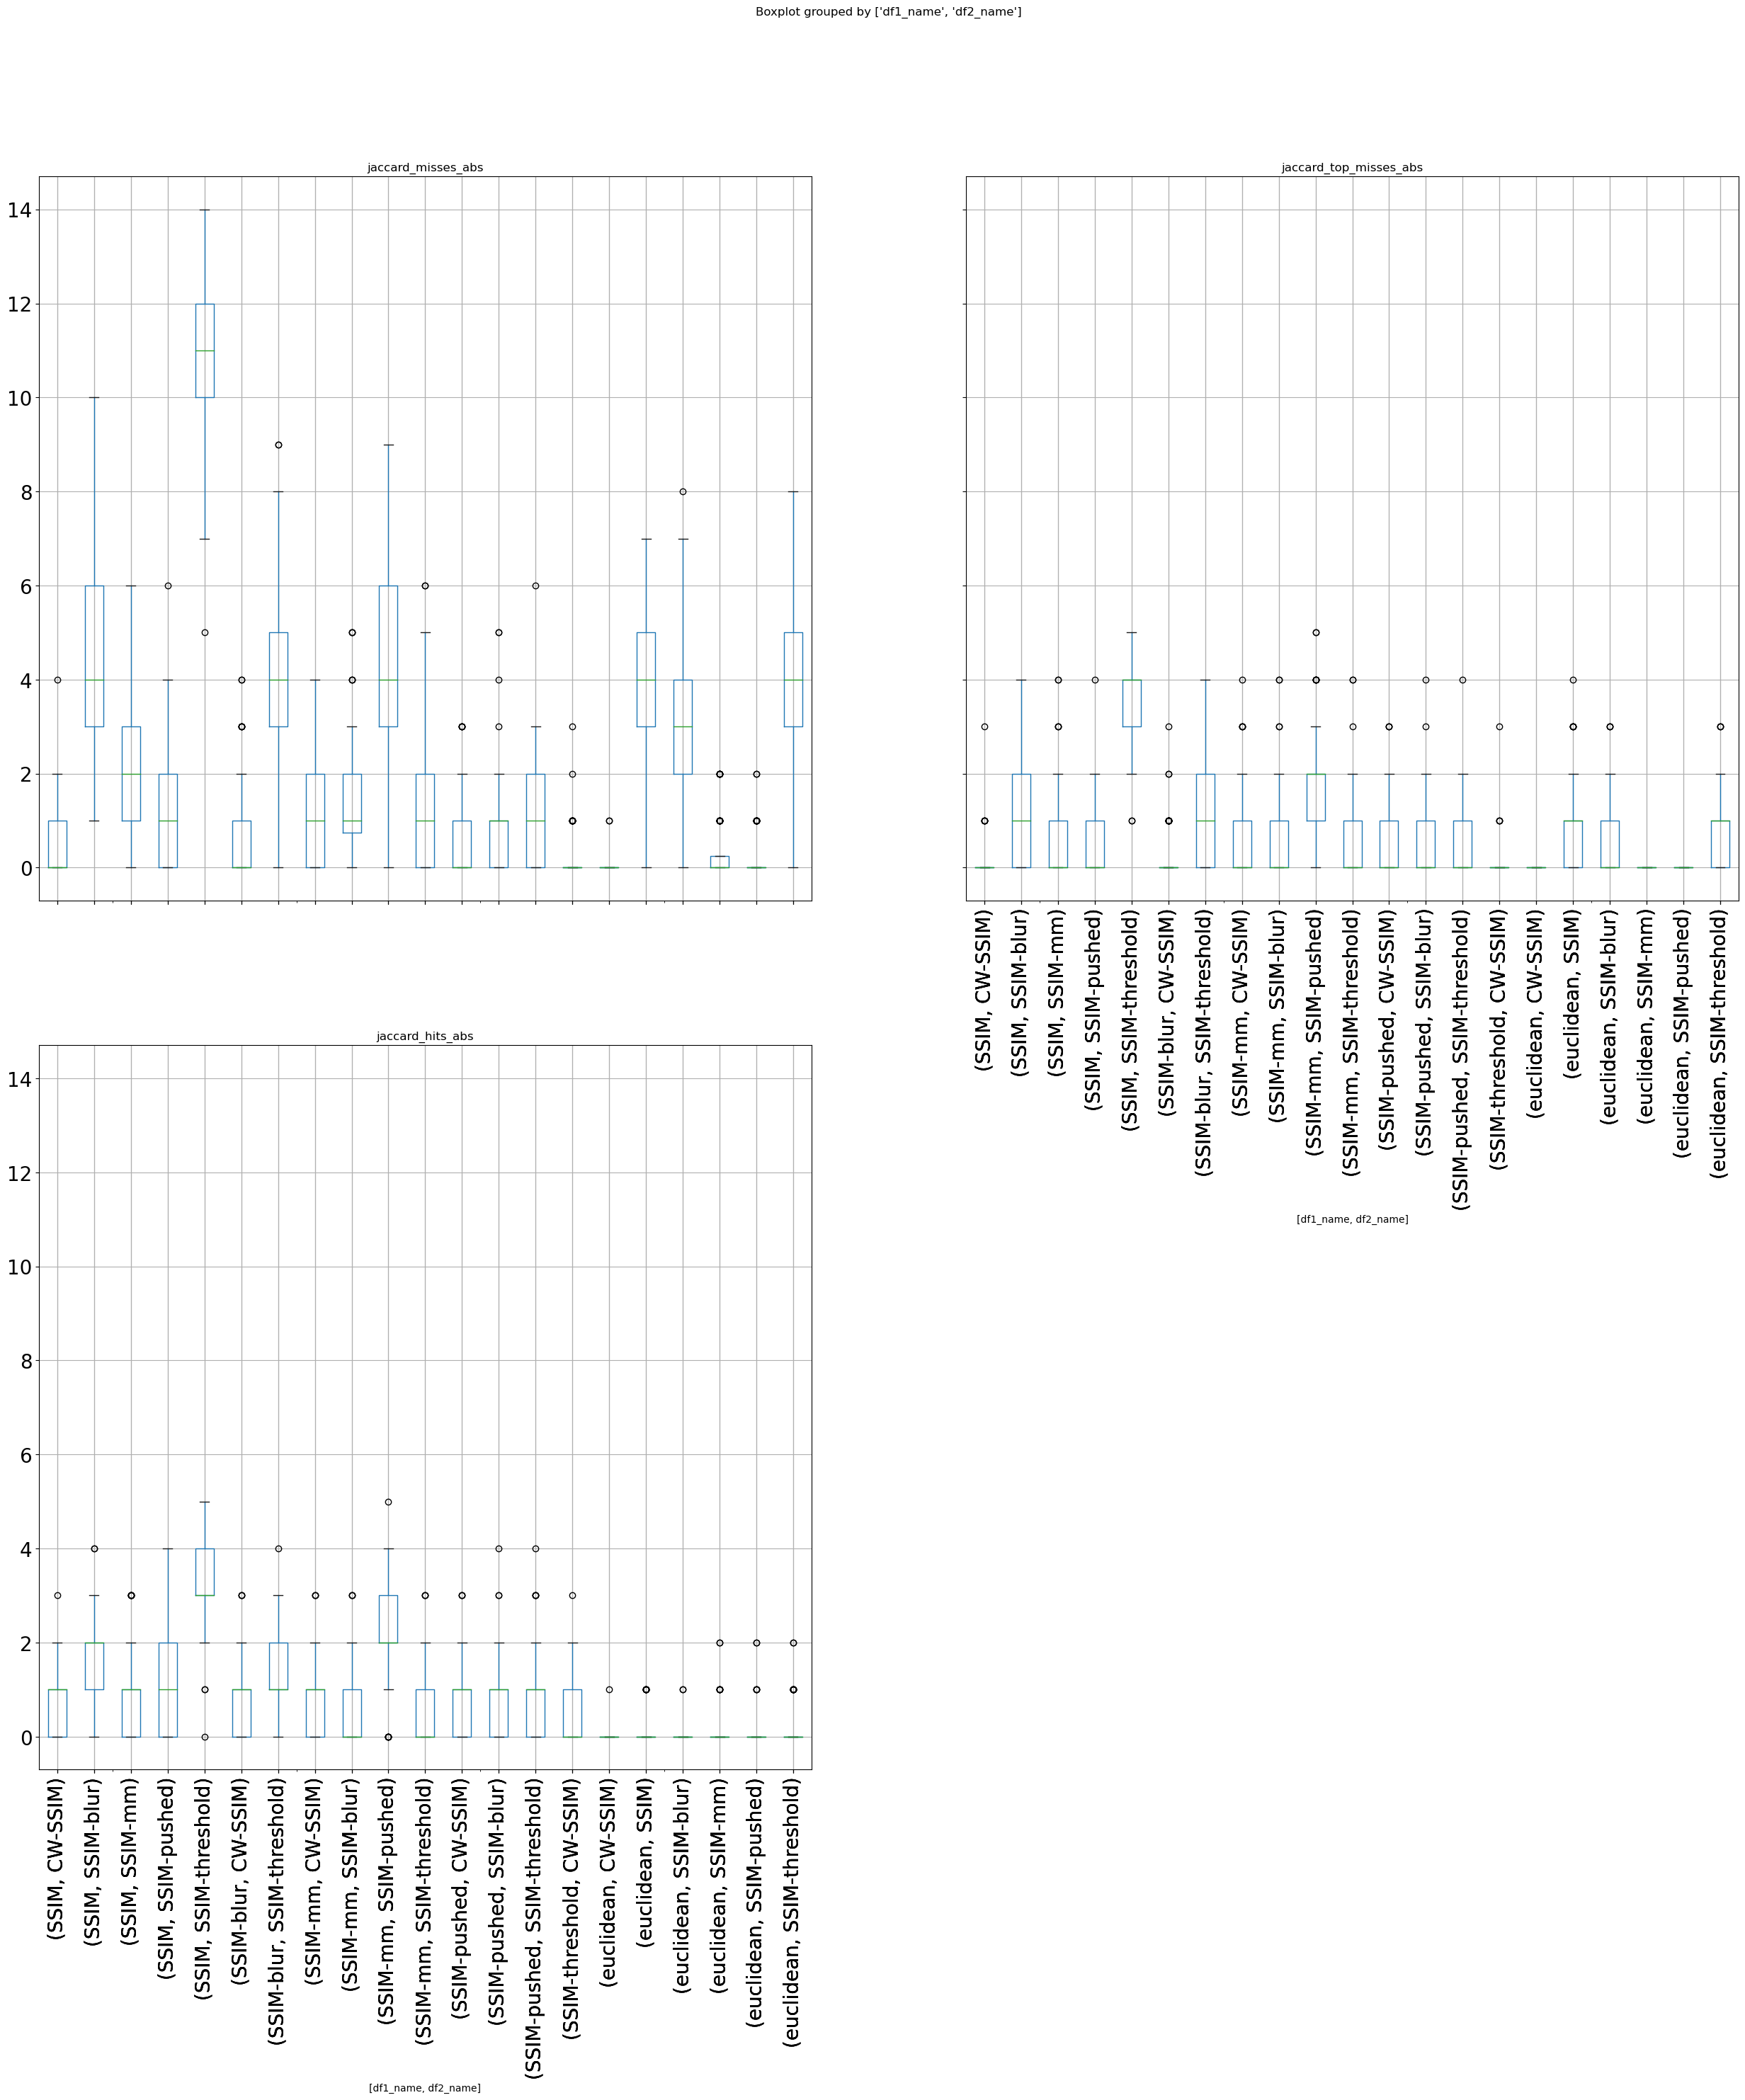

In [25]:
jaccards.boxplot(column=["jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"], by=["df1_name", "df2_name"],
                figsize=(30,30), rot = 90, fontsize=20)

#### Result:
* Since Jaccard index is a measure of similarity 0 means that A nad B are totally different
* Euclidean produces very different results from all SSIM metrics
* Maybe pushed and minmax are closes to each other
* SSIM threshold and SSIM produce similar results, this was to be expected when looking at the boxplots for the SSIM scores
* The other metrics produce quite but not totally different results

### OCT

In [26]:
jaccards_oct = pd.DataFrame()
for m1, df1 in oct_df.items():
    for m2, df2 in oct_df.items():
        # print(m1+"_"+m2)
        if m1 == m2:
            continue
        try:
            if m2 + "_" + m1 in np.array(jaccards_oct.group):
                continue
        except AttributeError:
            pass
        new = jaccard_nhnmtm(df1, df2, group=m1 + "_" + m2, df1_name=m1, df2_name=m2)
        jaccards_oct = pd.concat([jaccards_oct, new], ignore_index=True)

jaccards_oct

,jaccard_hits,jaccard_hits_abs,jaccard_misses,jaccard_misses_abs,jaccard_top_misses,jaccard_top_misses_abs,group,df1_name,df2_name
0,0.000000,0,0.000000,0,0.0,0,euclidean_SSIM,euclidean,SSIM
1,0.111111,1,0.000000,0,0.0,0,euclidean_SSIM,euclidean,SSIM
2,0.000000,0,0.000000,0,0.0,0,euclidean_SSIM,euclidean,SSIM
3,0.000000,0,0.000000,0,0.0,0,euclidean_SSIM,euclidean,SSIM
4,0.000000,0,0.000000,0,0.0,0,euclidean_SSIM,euclidean,SSIM
...,...,...,...,...,...,...,...,...,...
1495,0.000000,0,0.000000,0,0.0,0,SSIM-blur_SSIM-threshold,SSIM-blur,SSIM-threshold
1496,0.000000,0,0.000000,0,0.0,0,SSIM-blur_SSIM-threshold,SSIM-blur,SSIM-threshold
1497,0.000000,0,0.000000,0,0.0,0,SSIM-blur_SSIM-threshold,SSIM-blur,SSIM-threshold
1498,0.000000,0,0.000000,0,0.0,0,SSIM-blur_SSIM-threshold,SSIM-blur,SSIM-threshold


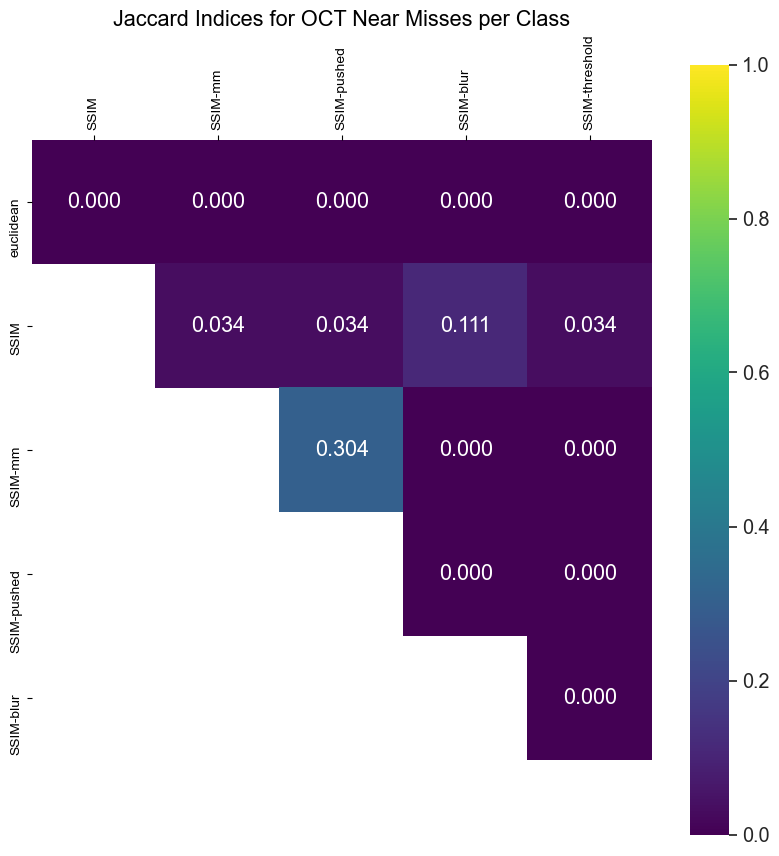

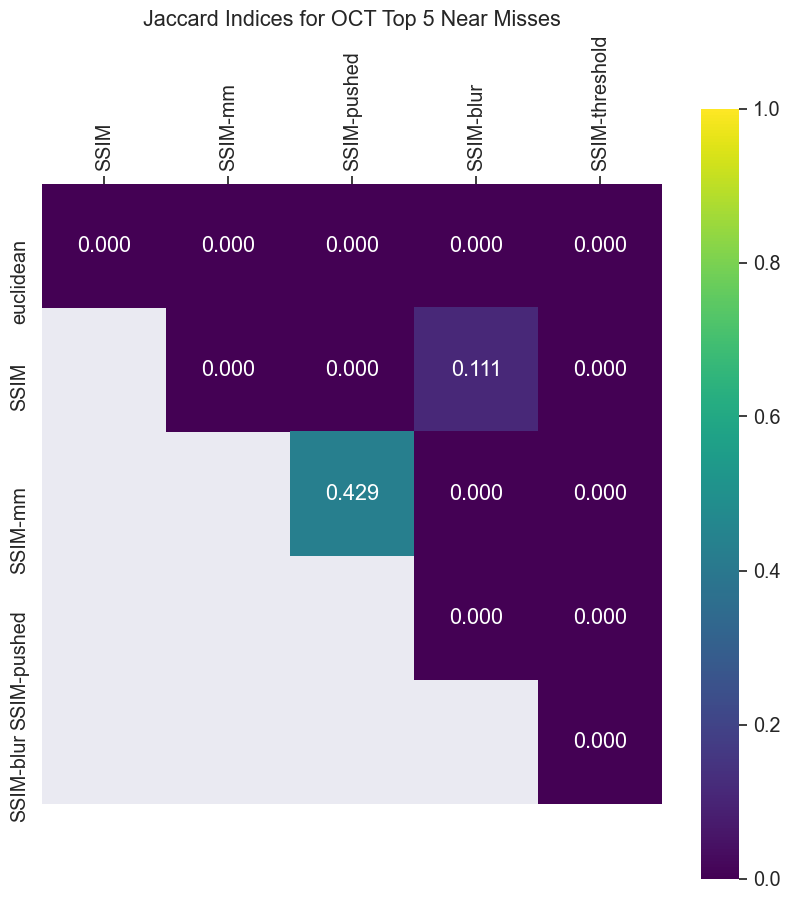

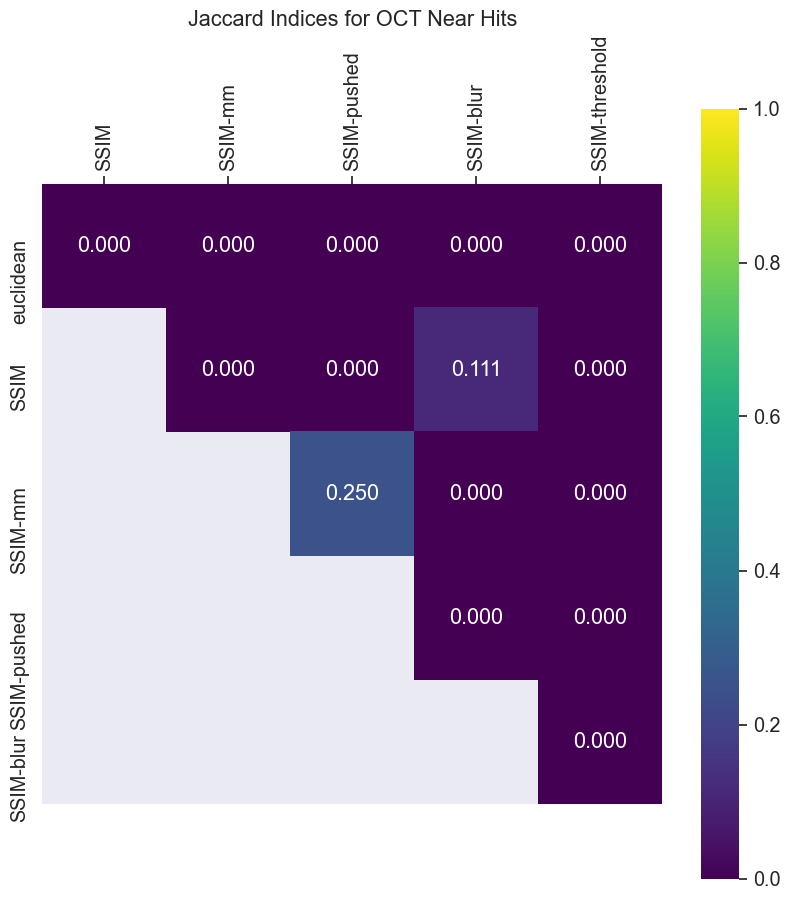

In [27]:
jaccards_heatmap(jaccards_oct, "jaccard_misses", vmax=1, title = "Jaccard Indices for OCT Near Misses per Class")
jaccards_heatmap(jaccards_oct, "jaccard_top_misses", vmax=1, title = "Jaccard Indices for OCT Top 5 Near Misses")
jaccards_heatmap(jaccards_oct, "jaccard_hits", vmax=1, title = "Jaccard Indices for OCT Near Hits")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4400b0d30>,
      dtype=object)

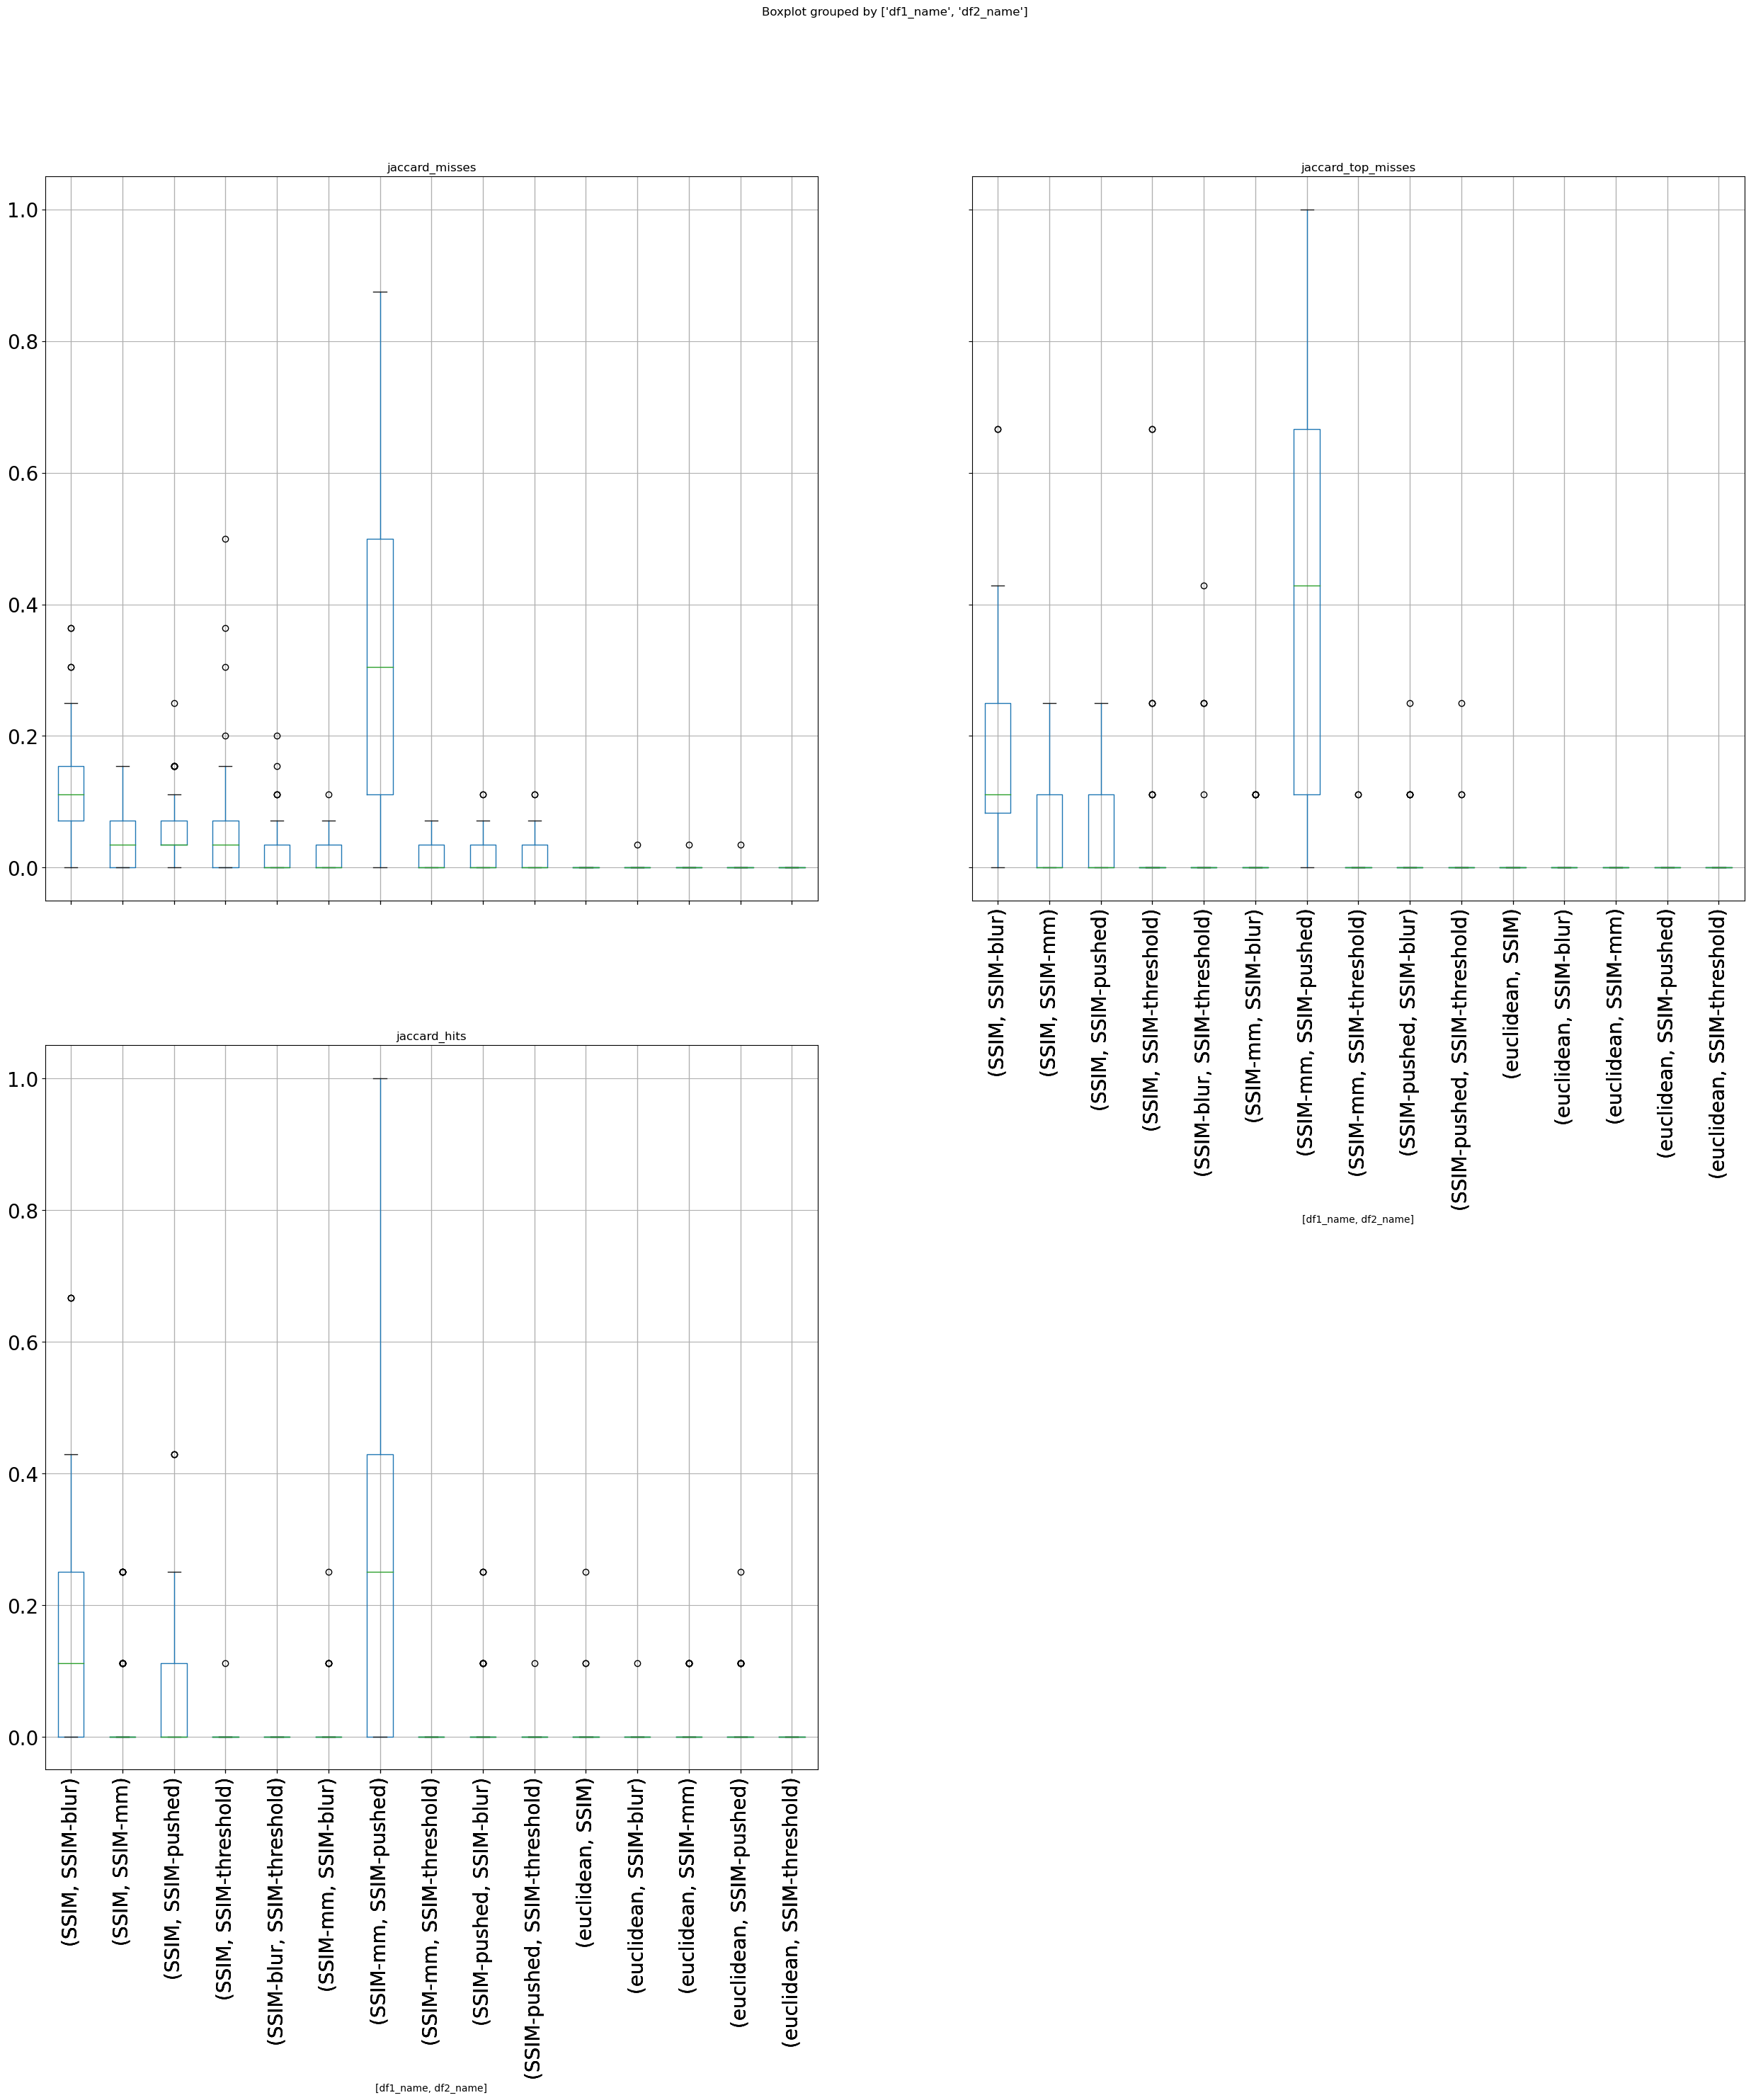

In [28]:
sns.reset_defaults()
jaccards_oct.boxplot(column=["jaccard_misses", "jaccard_top_misses", "jaccard_hits"], by=["df1_name", "df2_name"],
                 figsize=(30, 30), rot=90, fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc481658df0>,
      dtype=object)

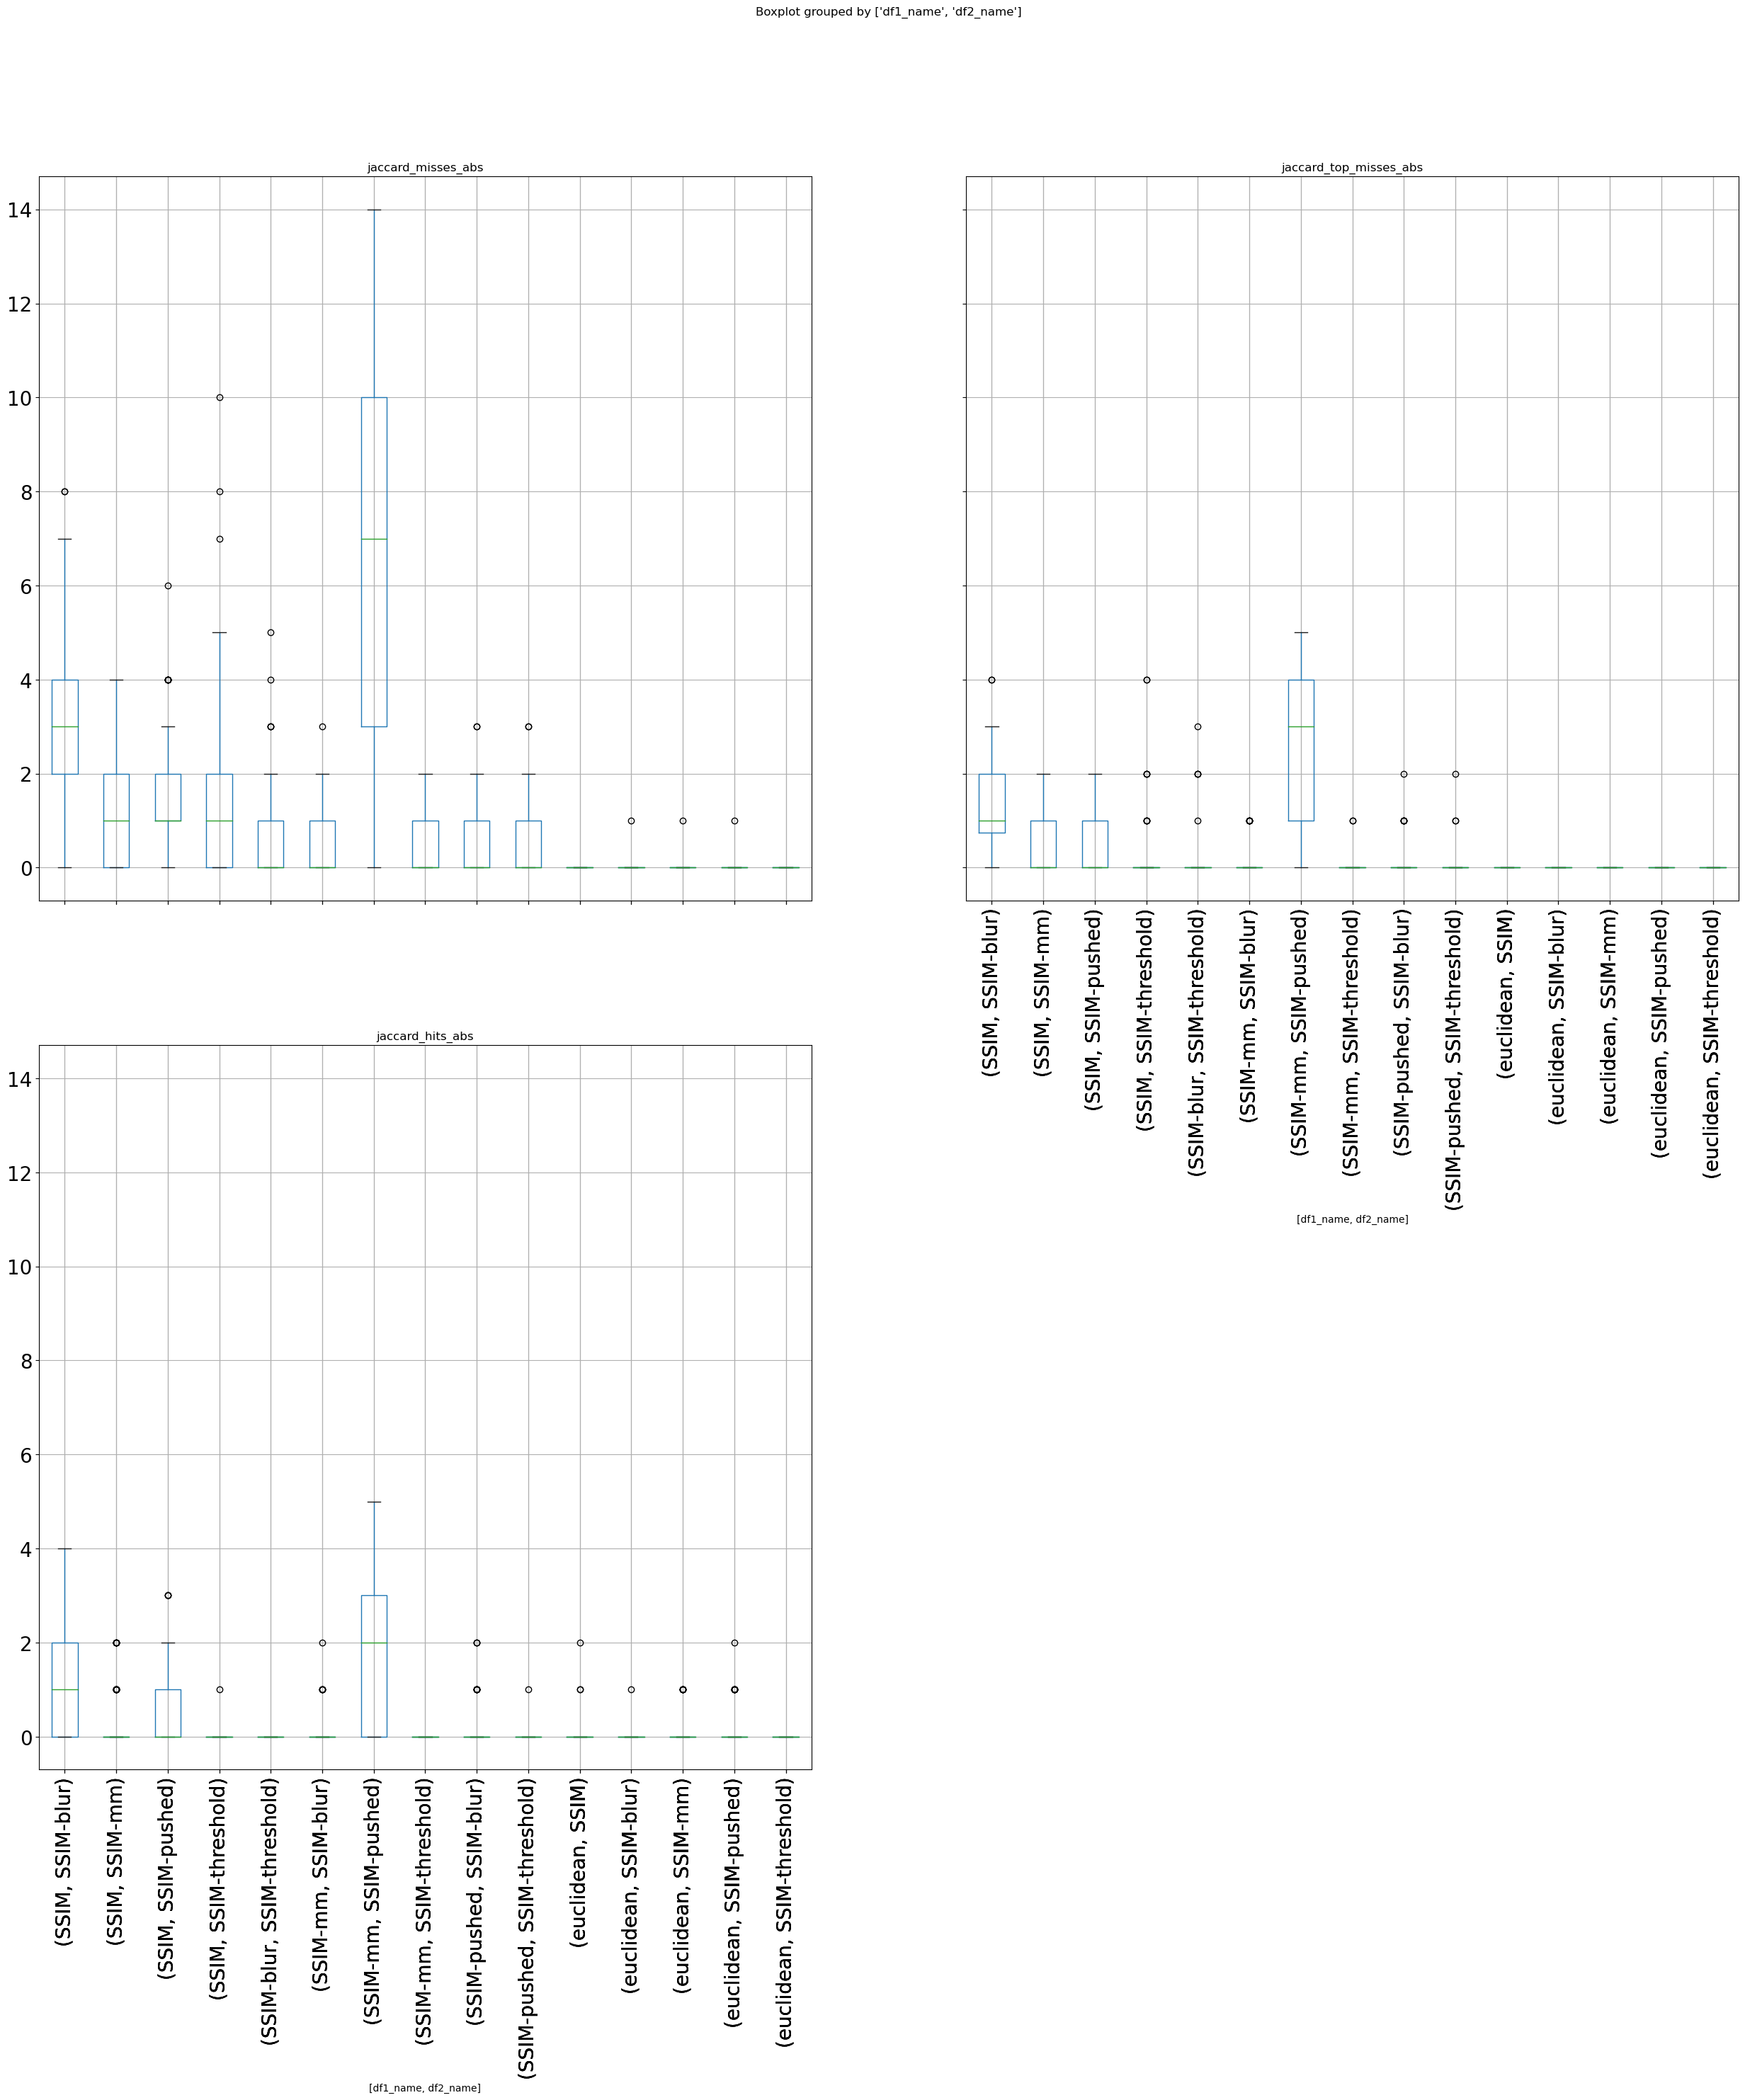

In [29]:
jaccards_oct.boxplot(column=["jaccard_misses_abs", "jaccard_top_misses_abs", "jaccard_hits_abs"],
                 by=["df1_name", "df2_name"],
                 figsize=(30, 30), rot=90, fontsize=20)

#### Results:
* Similar to mnist, but more prominent
* Except for the SSIM-threshold which seems to not give similar results to any of the other metrics. Only for the overall misses there are some overlaps to SSIM
* This is different to the mnist dataset

In [ ]:
plt.close("all")